# Predicting Forest Fires Area in Portugual


### Data Exploration


In [1]:
df_fires <- read.csv(file="forestfires.csv", header=TRUE, sep=",")

In [2]:
# First look at the data 
head(df_fires)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
2,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
3,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
6,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


It calls our attention the fact that the area is 0 in the first fires. Let's investigate a little bit this fact.

In [3]:
sum(round(df_fires$area,5) == 0.00000)

[1] 247

As we can see, there are 247 fires that the area is equal to 0. We will create an alternative table withouy this areas to continue our exploration. 

In [4]:
df_rfires <- df_fires[df_fires$area > 0, ] # rfires means real fires
cat(" Number of Rows in the dataset:", nrow(df_fires),"\n",
    "Number of Rows excluded:", nrow(df_fires) - nrow(df_rfires) , "\n",
    "Number of Rows remaining:", nrow(df_rfires))

 Number of Rows in the dataset: 517 
 Number of Rows excluded: 247 
 Number of Rows remaining: 270

From the new table we will start our exploration from the area of the fires. 

In [5]:
library(grid)
library(gridExtra)
library(ggplot2)
options(repr.plot.width=10, repr.plot.height=5)

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 82 rows containing missing values (geom_bar)."


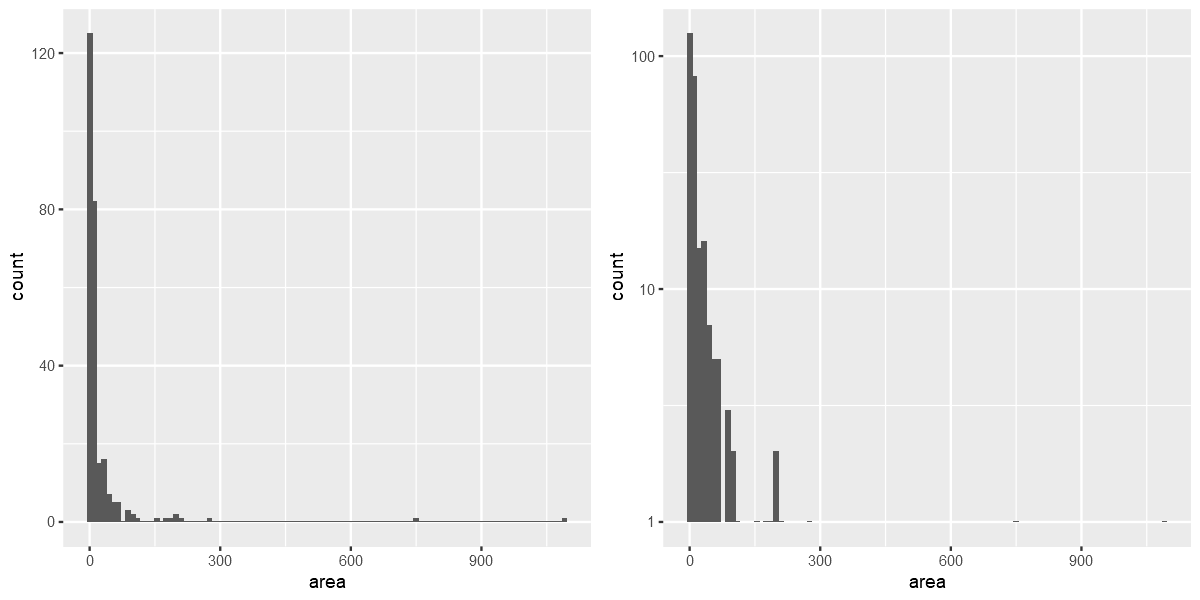

In [6]:
# par(mfrow=c(1,2))
p1 <- ggplot(df_rfires, aes(x=area)) + geom_histogram(bins = 100)
p2 <- ggplot(df_rfires, aes(x=area)) + geom_histogram(bins = 100) + scale_y_log10()
grid.arrange(p1, p2, nrow = 1)

To go further in this analysis lets build a table.

In [7]:
breaks = seq(range(df_rfires$area)[1], range(df_rfires$area)[2]+10, by=50)
df_rfires$size_area = cut(df_rfires$area, breaks, right=FALSE)

In [8]:
# install.packages("dplyr") ## install
# library(dplyr)

In [75]:
df_rfires %>%
  group_by(size_area) %>%
  summarize(Total_Area = sum(area, na.rm = TRUE),
            Count_Fires  = n())

size_area,Total_Area,Count_Fires
<fct>,<dbl>,<int>
"[0.09,50.1)",2280.89,246
"[50.1,100)",910.89,13
"[100,150)",209.05,2
"[150,200)",711.75,4
"[200,250)",413.82,2
"[250,300)",278.53,1
"[700,750)",746.28,1
"[1.05e+03,1.1e+03)",1090.84,1


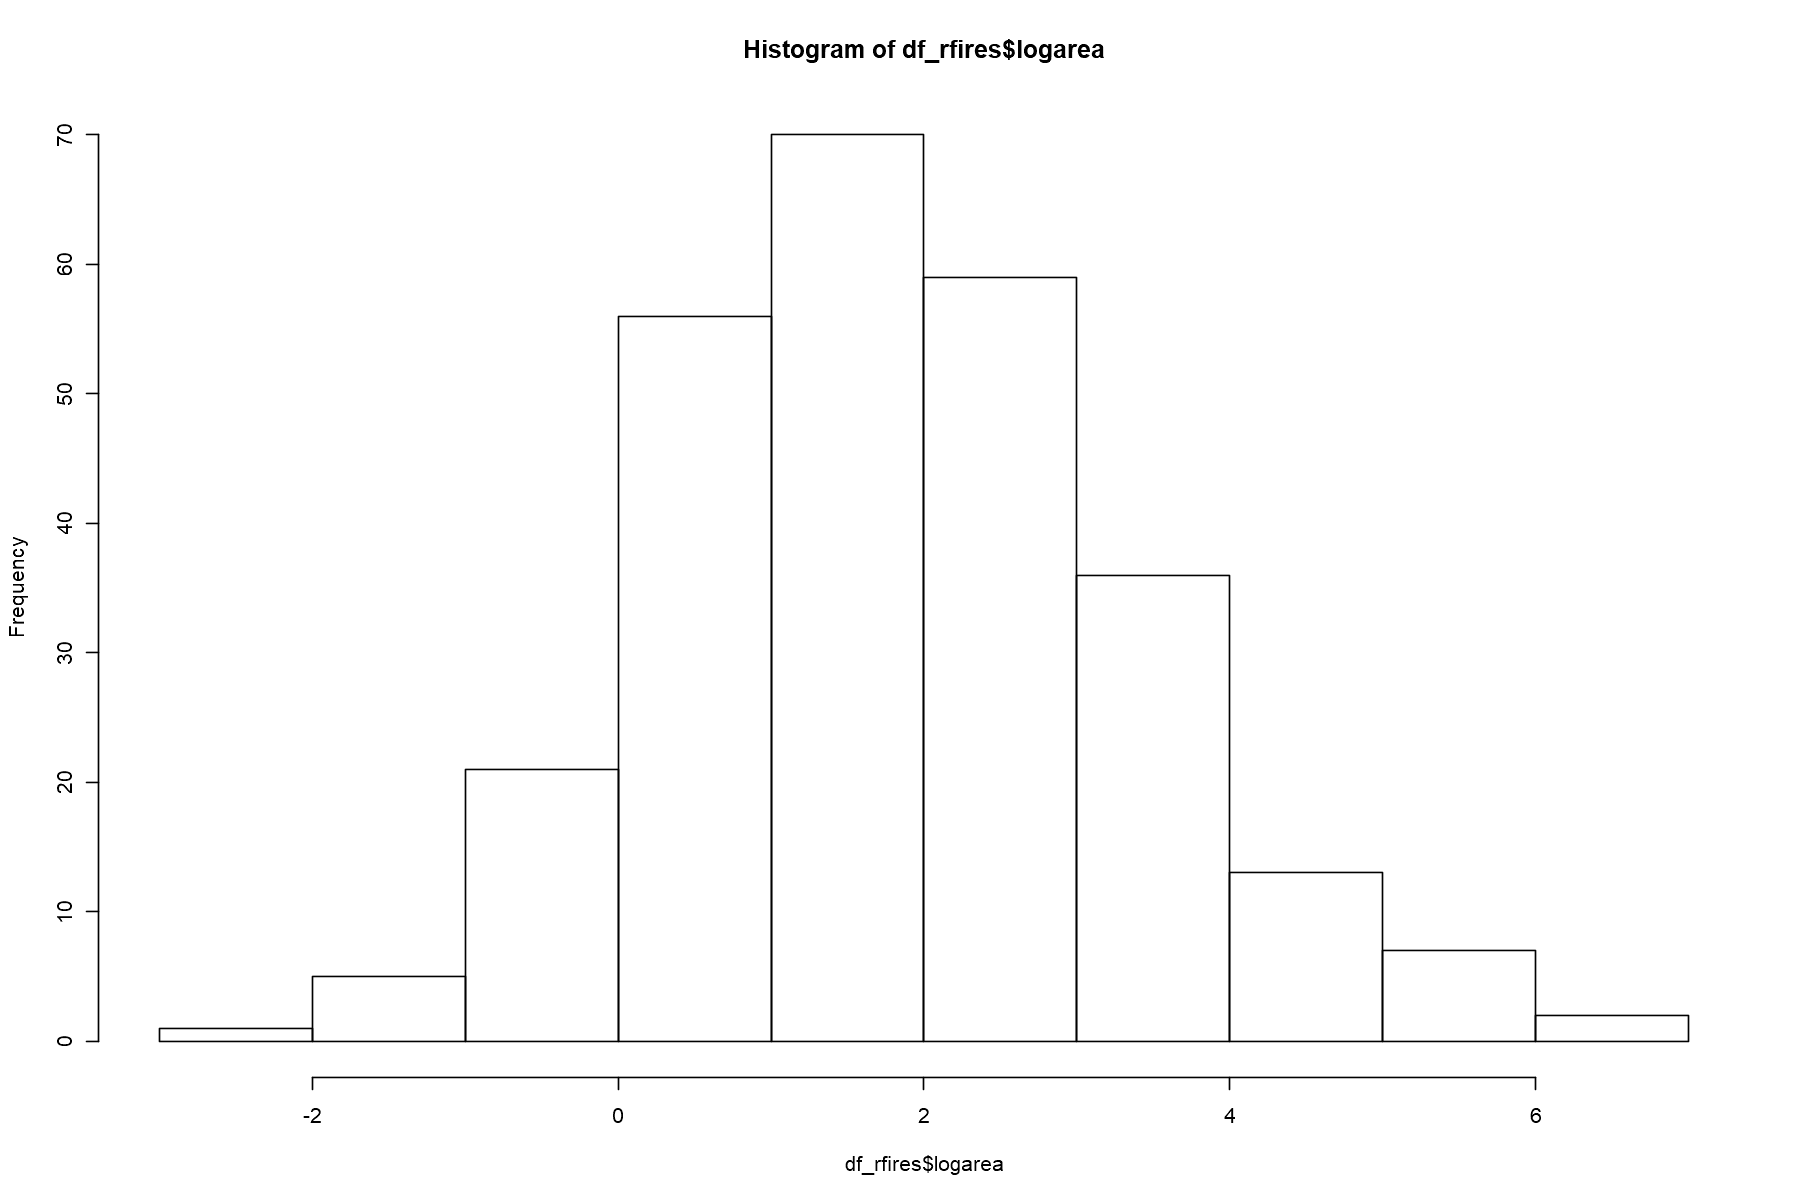

In [35]:
df_rfires$logarea <- ifelse(df_rfires$area > 0, log(df_rfires$area), NA)
hist(df_rfires$logarea)

### Attribute information:


   - `X`:      x-axis spatial coordinate within the Montesinho park map: 1 to 9
   -  `Y`:     y-axis spatial coordinate within the Montesinho park map: 2 to 9
   - `month`:  month of the year: "jan" to "dec" 
   - `day`:    day of the week: "mon" to "sun"
   - `FFMC`:   FFMC index from the FWI system: 18.7 to 96.20
   - `DMC`:    DMC index from the FWI system: 1.1 to 291.3 
   - `DC`:     DC index from the FWI system: 7.9 to 860.6 
   - `ISI`:    ISI index from the FWI system: 0.0 to 56.10
   - `temp`:   temperature in Celsius degrees: 2.2 to 33.30
   - `RH`:     relative humidity in %: 15.0 to 100
   - `wind`:   wind speed in km/h: 0.40 to 9.40 
   - `rain`:   outside rain in mm/m2 : 0.0 to 6.4 
   - `area`:   the burned area of the forest (in ha): 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform). 

### Explore correlations

In [33]:
# install.packages("PerformanceAnalytics")
library("PerformanceAnalytics")

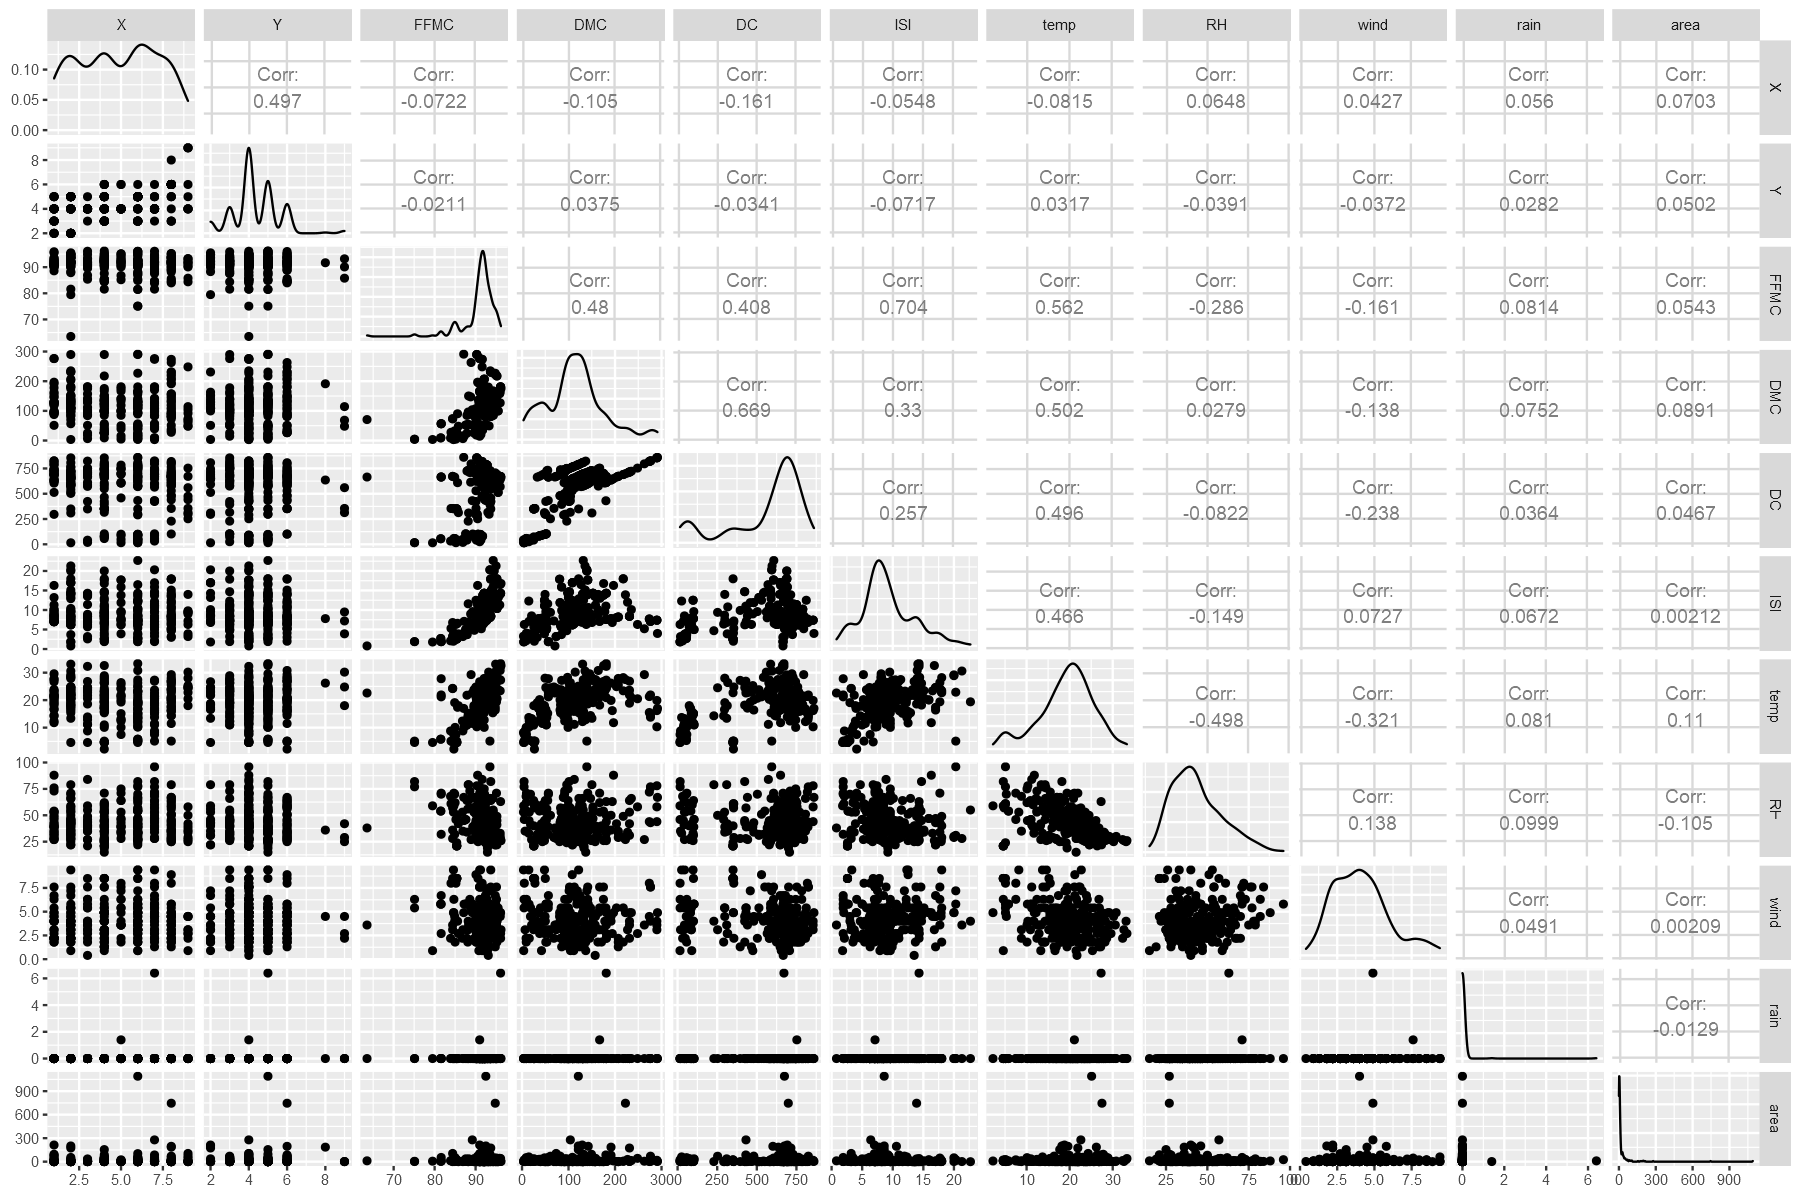

In [31]:
options(repr.plot.width=15, repr.plot.height=10)
ggpairs(df_rfires[,c(1,2,seq(5,13))])

In [11]:
library(lattice)

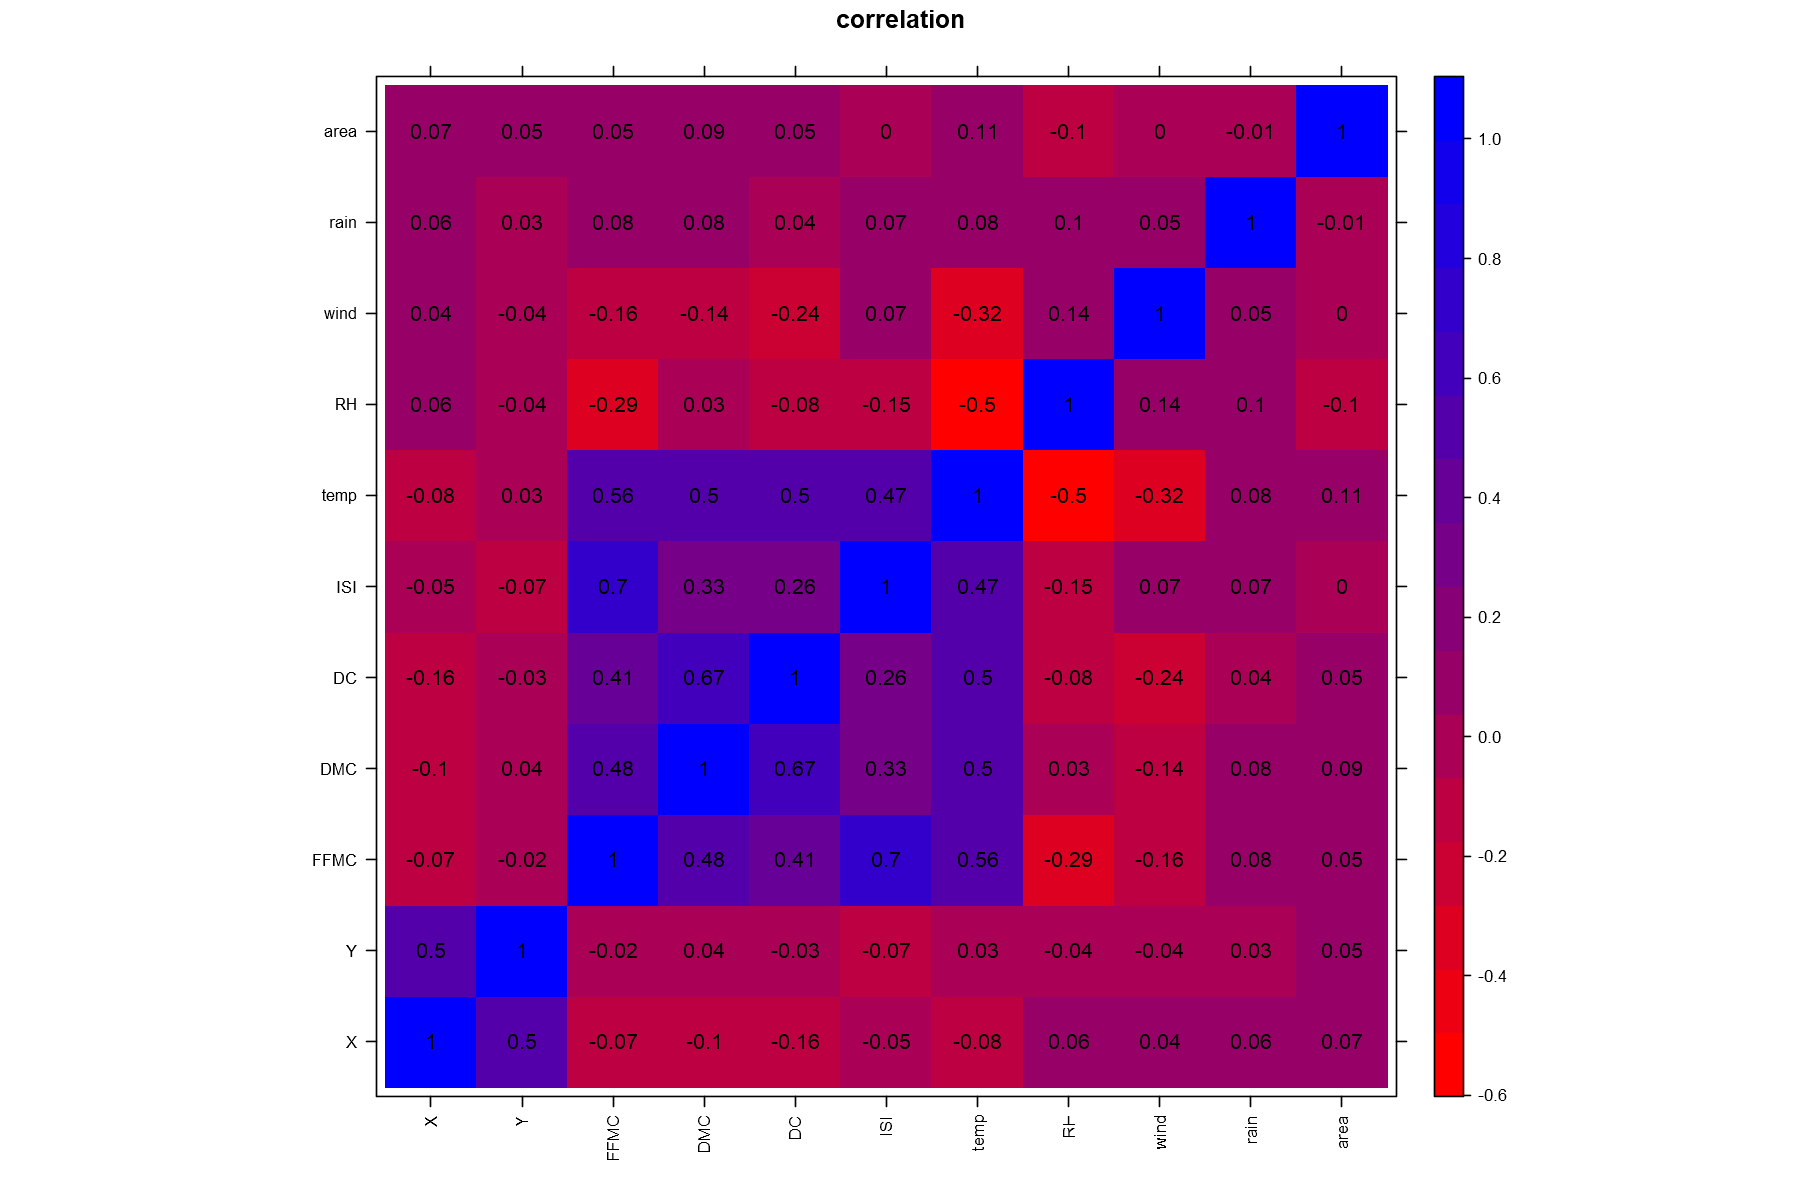

In [12]:
#Define you own panel
myPanel <- function(x, y, z, ...) {
    panel.levelplot(x,y,z,...)
    panel.text(x, y, round(z, 2))
}
#Define the color scheme
cols = colorRampPalette(c("red","blue"))
#Plot the correlation matrix.
levelplot(cor(df_rfires[,c(1,2,seq(5,13))]), col.regions = cols(100), main = "correlation", xlab = NULL, ylab = NULL, 
          scales = list(x = list(rot = 90)), panel = myPanel)

### Exploring seasonality.

By logic, we discharge the possibility that the day of the week may provoce a fire.  Firstly, lets create a new column called season.

In [23]:
library(dplyr)

In [24]:
df_rfires$season <- ifelse(df_rfires$month == "dec" | df_rfires$month == "jan" | df_rfires$month == "feb",'summer', 
                          ifelse(df_rfires$month == "mar" | df_rfires$month == "apr" | df_rfires$month == "may","autumn",
                                 ifelse(df_rfires$month == "jun" | df_rfires$month == "jul" | df_rfires$month =="aug", "winter",
                                        ifelse(df_rfires$month == "sep" | df_rfires$month == "oct" | df_rfires$month =='nov', "spring", 'NA'))))

In [25]:
df_rfires %>%
  group_by(season) %>%
  summarize(Total_Area = sum(area, na.rm = TRUE),
            Count_Fires  = n())

season,Total_Area,Count_Fires
<chr>,<dbl>,<int>
autumn,353.76,24
spring,3185.70,102
summer,245.47,19
winter,2857.12,125


### starting the regression

In [26]:
library(ISLR)
library(ggplot2)
library(GGally)
library(gridExtra)
library(cowplot)

In [37]:
head(df_rfires)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_area,season,logarea
,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<dbl>
139,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0,0.36,"[0.09,50.1)",winter,-1.0216512
140,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0,0.43,"[0.09,50.1)",spring,-0.8439701
141,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0,0.47,"[0.09,50.1)",spring,-0.7550226
142,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0,0.55,"[0.09,50.1)",winter,-0.5978370
143,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0,0.61,"[0.09,50.1)",winter,-0.4942963
144,1,2,jul,sat,90.0,51.3,296.3,8.7,16.6,53,5.4,0,0.71,"[0.09,50.1)",winter,-0.3424903


### Regression against quantitative variables 

In [63]:
mod <- lm(logarea ~ ., data=df_rfires[c(seq(1,12),14,15,16)])

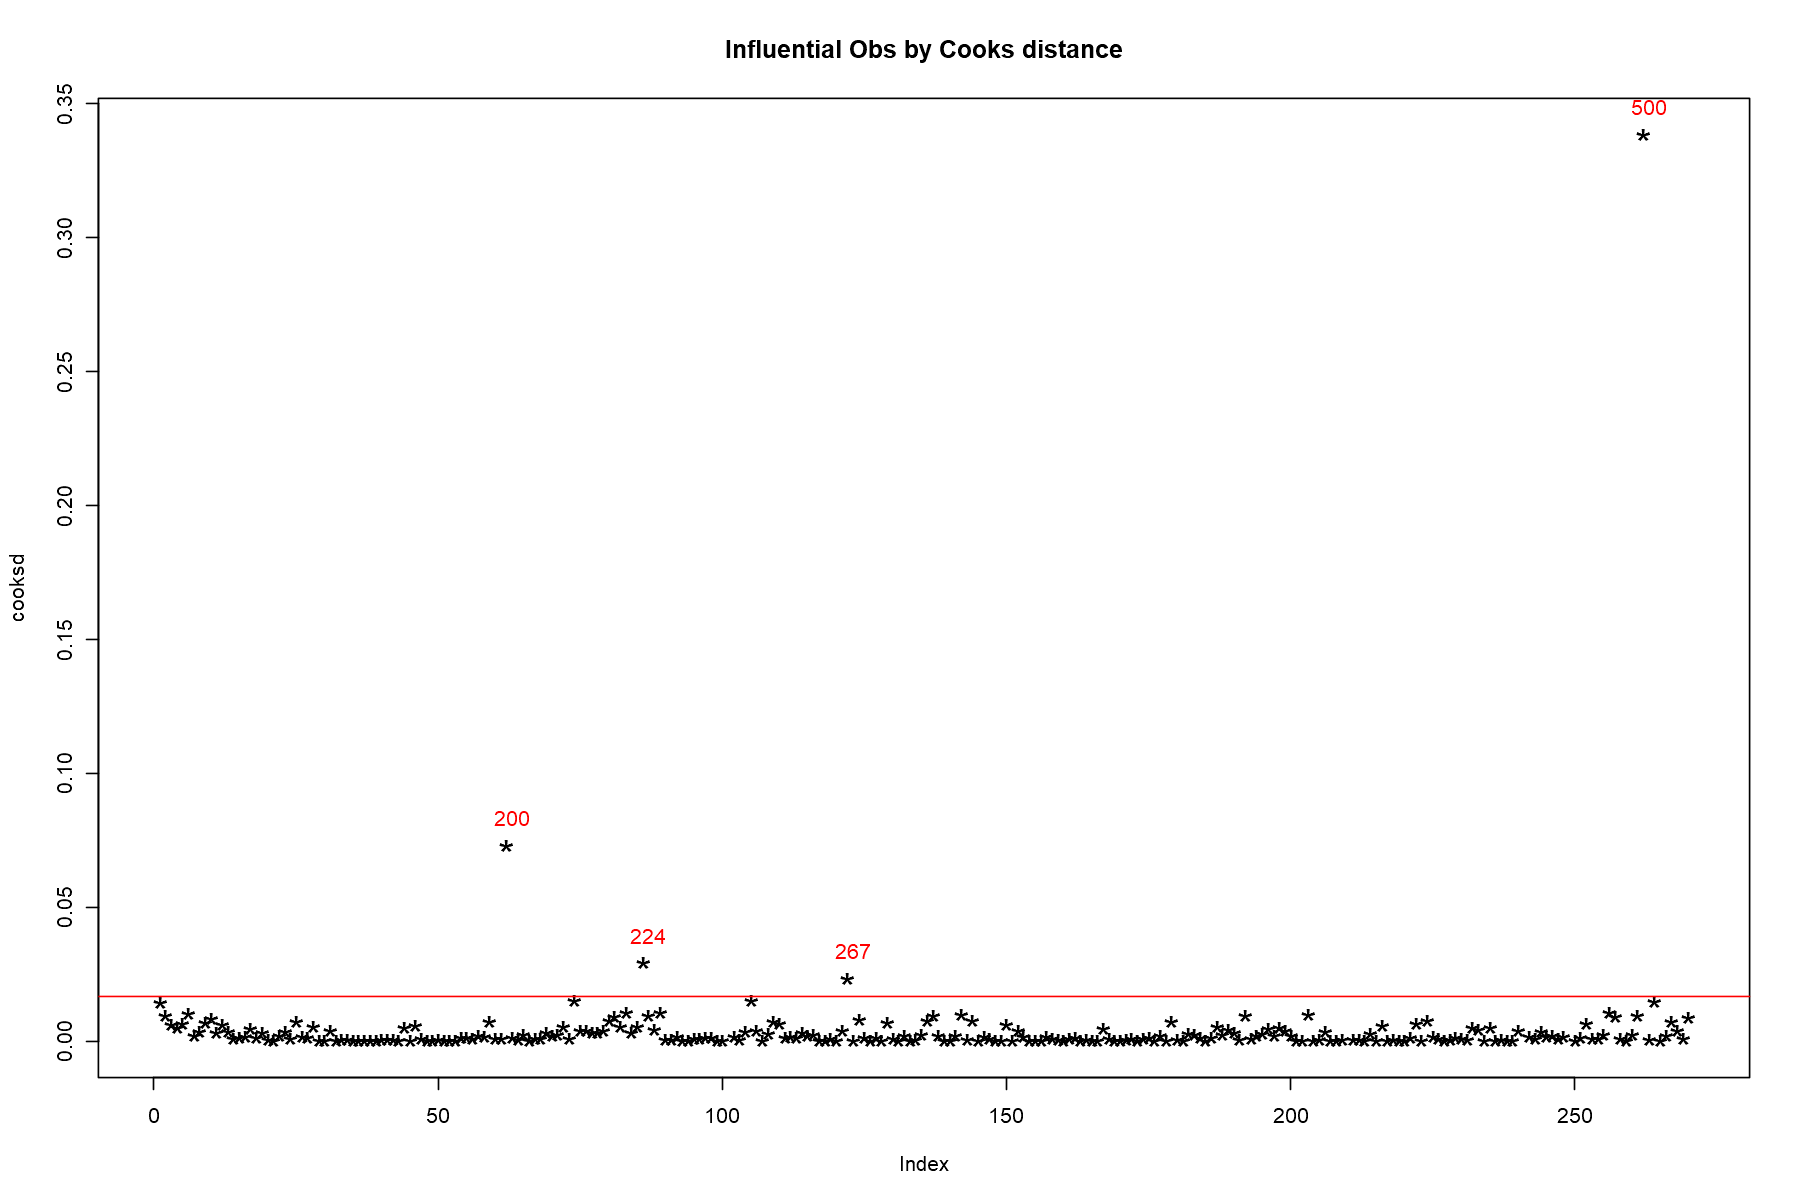

In [61]:
cooksd <- cooks.distance(mod)
plot(cooksd, pch="*", cex=2, main="Influential Obs by Cooks distance")  # plot cook's distance
abline(h = 4*mean(cooksd, na.rm=T), col="red")  # add cutoff line
text(x=1:length(cooksd)+1, y=cooksd+0.01, labels=ifelse(cooksd>4*mean(cooksd, na.rm=T),names(cooksd),""), col="red")  # add labels

In [53]:
influential = which(cooksd>4*mean(cooksd, na.rm=T))
df_rfires[influential, ]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_area,season,logarea
,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<dbl>
200,2,4,sep,mon,63.5,70.8,665.3,0.8,22.6,38,3.6,0.0,11.32,"[0.09,50.1)",spring,2.426571
224,2,2,jul,fri,88.3,150.3,309.9,6.8,13.4,79,3.6,0.0,37.02,"[0.09,50.1)",winter,3.611458
267,6,5,aug,tue,94.3,131.7,607.1,22.7,19.4,55,4.0,0.0,0.17,"[0.09,50.1)",winter,-1.771957
500,7,5,aug,tue,96.1,181.1,671.2,14.3,27.3,63,4.9,6.4,10.82,"[0.09,50.1)",winter,2.381396


For now, let's remove outliers.

In [68]:
new_df_rfires = df_rfires[-influential, ]

In [69]:
influential

200 224 267 500 
 62  86 122 262

### Model Build

In [71]:
new_data <- rbind(new_df_rfires[which(df_fires$area == 0),],new_df_rfires)
new_data$b_area <- ifelse(new_data$area == 0, 0, 1)

ERROR: Error in rbind(deparse.level, ...): numbers of columns of arguments do not match


In [74]:
head(df_rfires)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_area,season,logarea
,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<dbl>
139,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0,0.36,"[0.09,50.1)",winter,-1.0216512
140,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0,0.43,"[0.09,50.1)",spring,-0.8439701
141,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0,0.47,"[0.09,50.1)",spring,-0.7550226
142,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0,0.55,"[0.09,50.1)",winter,-0.5978370
143,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0,0.61,"[0.09,50.1)",winter,-0.4942963
144,1,2,jul,sat,90.0,51.3,296.3,8.7,16.6,53,5.4,0,0.71,"[0.09,50.1)",winter,-0.3424903


In [73]:
head(df_fires)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
2,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
3,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
6,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0
